# 신경회로망 특론 Term Project

## MobileNet-V2를 이용한 스시오마카세 메뉴 자동 분류 시스템

### Dataset 구축


본 프로젝트에 사용한 데이터는 총 292장의 스시오마카세 이미지들로서 25가지의 카테고리가 있음
데이터는 학습 데이터 (70%), 검증 데이터(10%), 평가 데이터(20%)로 나누어 저장
특히 Raw Data는 데이터의 효율적인 전처리를 위하여 아래의 구조를 갖도록 재구조화 해야함
(preprocessed_data 폴더에 본 프로젝트에서 사용한 데이터가 있음)
```
/datadir
    /train
            /class_1
            /class_2
            .
            .
    /valid
            /class_1
            /class_2
            .
            .
    /test
            /class_1
            /class_2
            .
            .
```

### Code implementation

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams["font.family"] = 'NanumBarunGothic'

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

### Hyperparameters

TODO: data경로는 본인의 서버 환경에 맞게 재설정해야함

In [40]:
# Datapath 설정하기
datadir = '/home/nlplab/v2_Development/yoonseok/yoon_proj/preprocessed_data'
traindir = os.path.join(datadir, "train")
validdir = os.path.join(datadir, "valid")
testdir = os.path.join(datadir, "test")

#save_file_name = 'mobileNet_v2-transfer-4.pt'
save_file_name = 'mobilenet_v2-transfer-4.pt'
checkpoint_path = 'mobilenet_v2-transfer-4.pth'

# Change to fit hardware
batch_size = 128

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
2 gpus detected.


### Data Analysis

수집한 스시 오마카세 데이터의 구성을 확인 가능

In [15]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(os.path.join(traindir, d))
    valid_imgs = os.listdir(os.path.join(validdir, d))
    test_imgs = os.listdir(os.path.join(testdir, d))
    
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + '/' + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

n_classes = len(cat_df)
print(f'  >>There are {n_classes} different classes.')

#len(data['train'].classes)
cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()
cat_df.tail()

  >>There are 25 different classes.


,category,n_train,n_valid,n_test
21,찐전복,12,3,7
0,흑점줄전갱이,9,3,6
3,가다랑어간장절임,8,2,5
1,보탄에비,8,2,5
10,아귀간,8,3,5


,category,n_train,n_valid,n_test
23,학꽁치,4,1,3
4,성게,4,1,3
17,옥돔 튀김,3,1,2
15,달걀구이,3,1,3
5,박고지김밥,1,1,2


#### 데이터 분포

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training Images by Category')

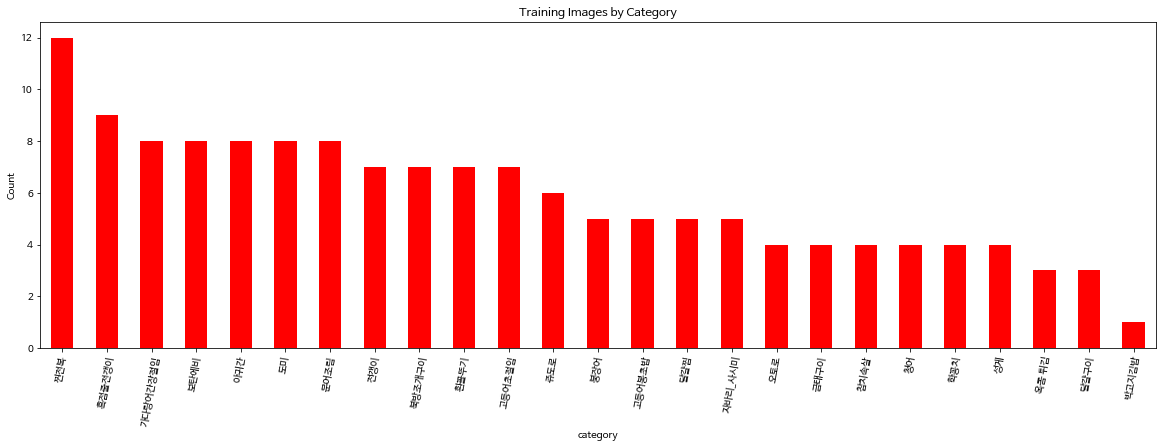

In [5]:
cat_df.set_index('category')['n_train'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

#### Sample Data

(256, 256, 3)

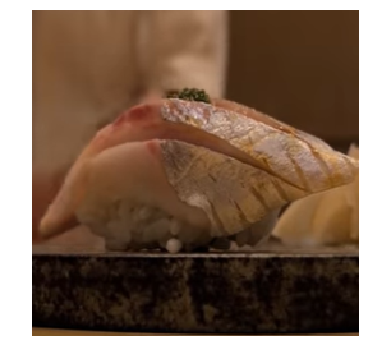

In [6]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Example image
x = Image.open(traindir + '/' + '청어/4.PNG').convert('RGB')
np.array(x).shape
imshow(x)

### Image Preprocessing

In [7]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### Example for Data Augmentation 

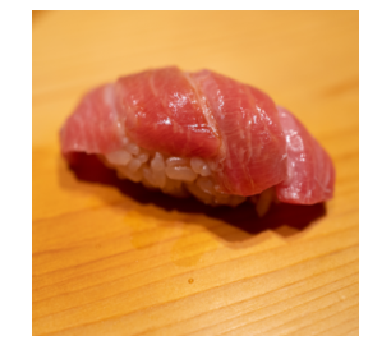

In [11]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

ex_img = Image.open(os.path.join(traindir, '오토로/4.PNG')).convert('RGB')
imshow(ex_img)

<Figure size 1728x1728 with 0 Axes>

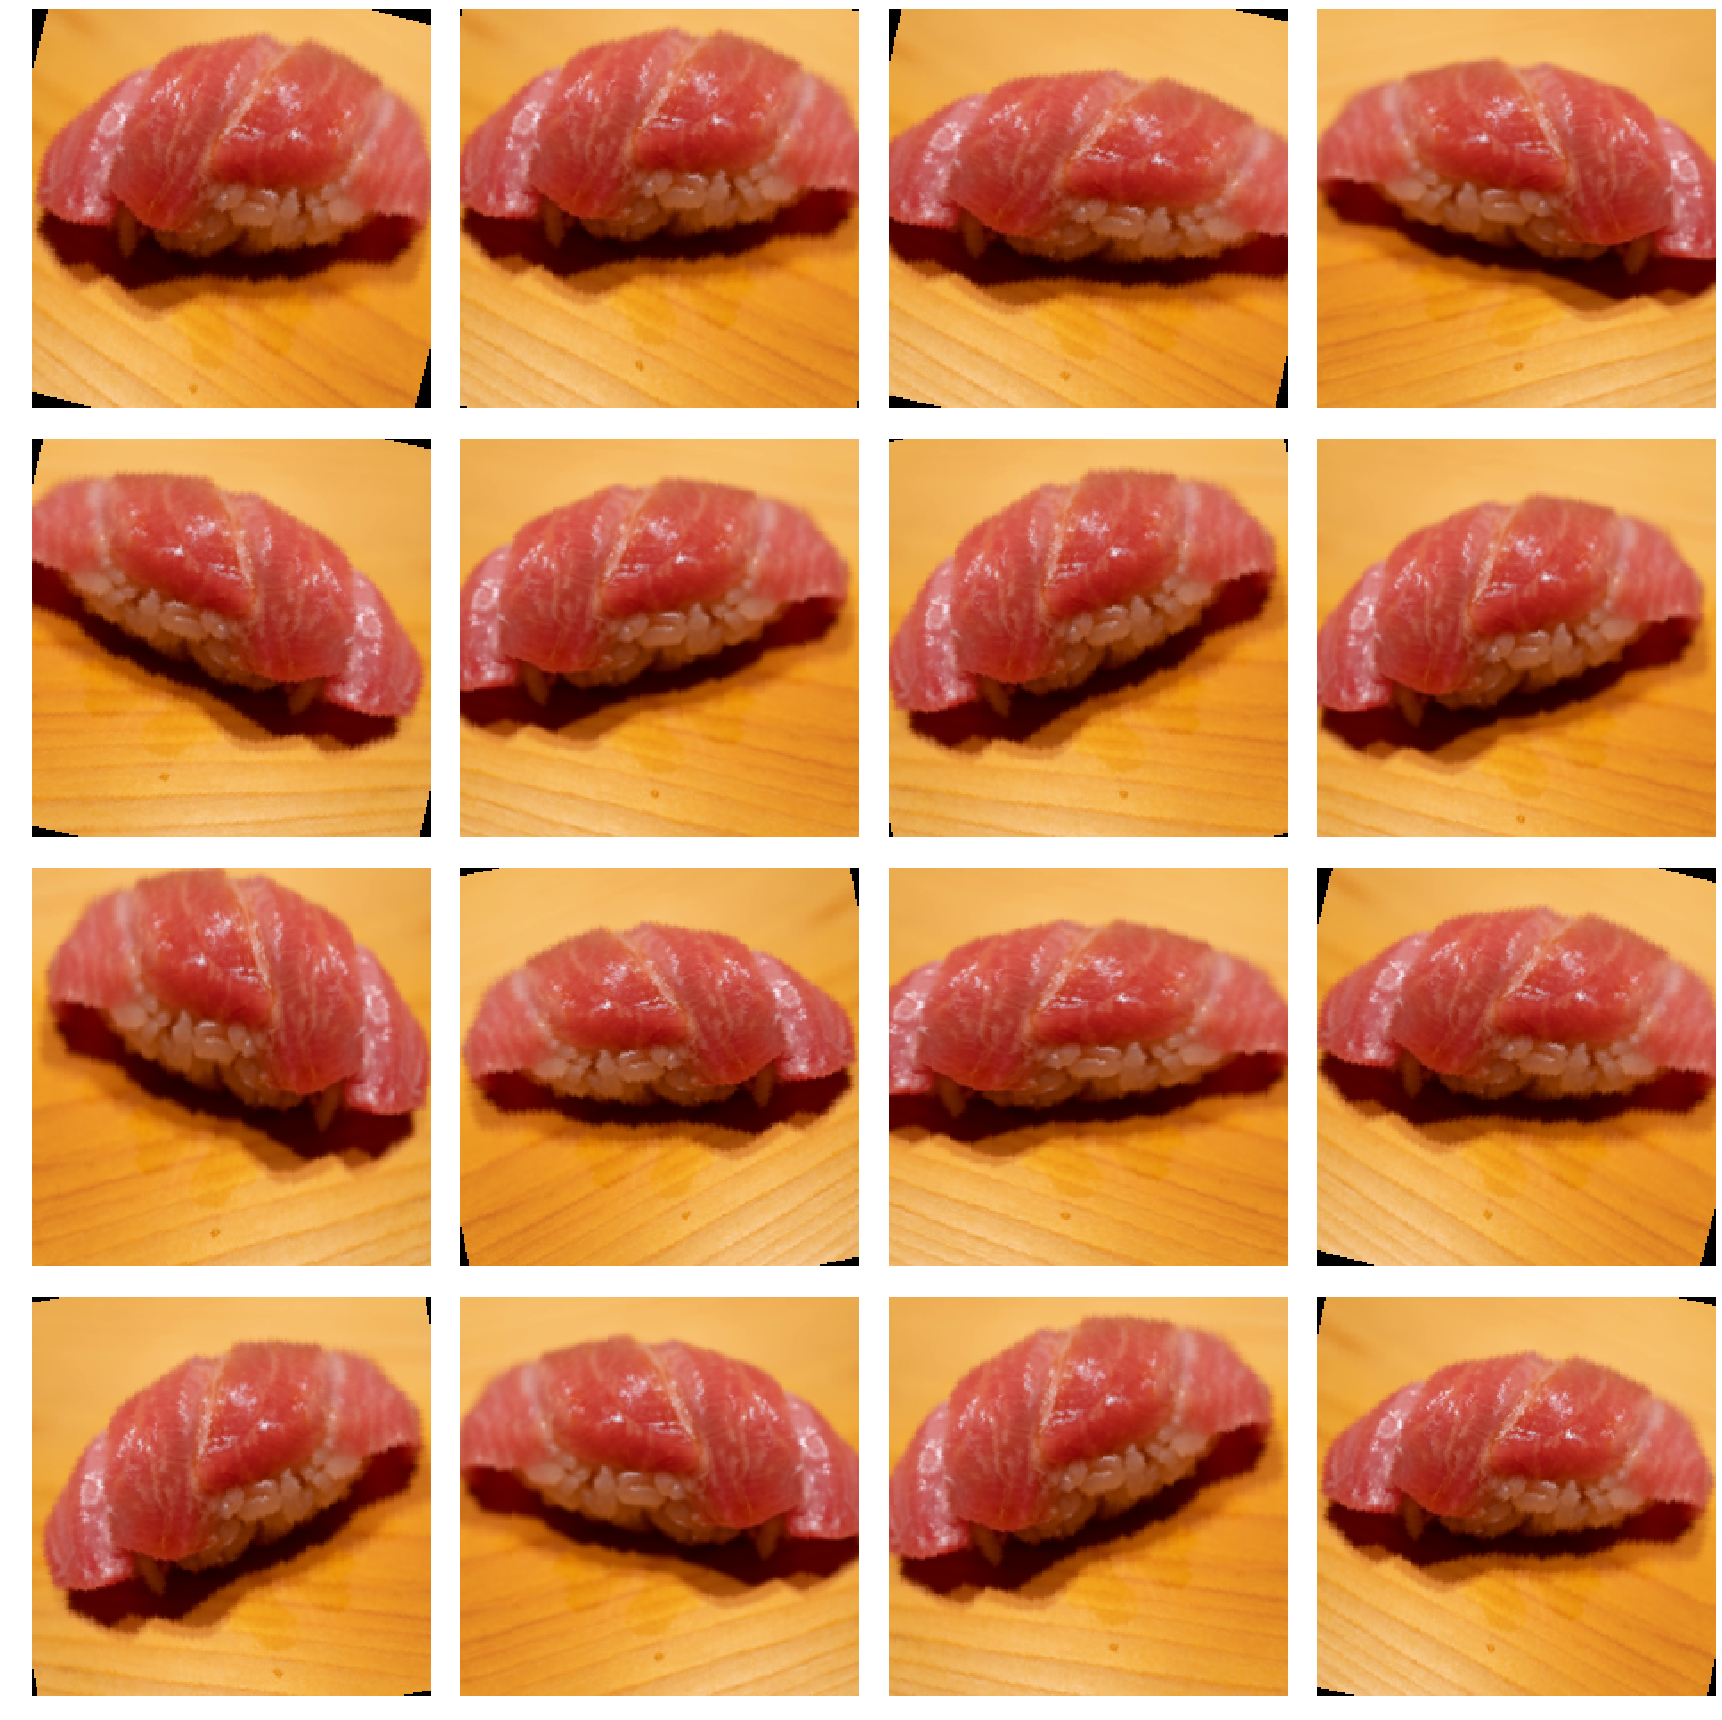

In [12]:
t = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

### Data Iterators

In [17]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

Batch의 Dimension:  `(batch_size, color_channels, height, width)`

## Model Fine-tuning

본 코드에서는 베이스라인인 VGG-16과 제안 모델에서 사용하는 네트워크인 MobileNet-v2를 사용할 수 있음.

### Load the model with pretrained weights

In [20]:
model = models.mobilenet_v2(pretrained=True)
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

### Parameter Freezing

In [21]:
for param in model.parameters():
    param.requires_grad = False

### Add a customized classifier
mobilenet-v2 기준

In [25]:
""" VGGNet-16
n_inputs = model.classifier[6].in_features
model.classifier[1] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))
"""

n_inputs = model.last_channel

model.classifier[1] = nn.Sequential(
    nn.Linear(n_inputs, n_classes), 
    nn.LogSoftmax(dim=1))

model.classifier

' VGGNet-16\nn_inputs = model.classifier[6].in_features\nmodel.classifier[1] = nn.Sequential(\n    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.3),\n    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))\n'

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Sequential(
    (0): Linear(in_features=1280, out_features=25, bias=True)
    (1): LogSoftmax()
  )
)

In [26]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

2,255,897 total parameters.
32,025 training parameters.


### GPU Loading

In [27]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

#### 위의 과정을 함수로 다시 정리하여 재사용 가능하게 구현

In [28]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))
    
    elif model_name == 'mobileNet_v2' or 'mobileNet':
        model = models.mobilenet_v2(pretrained=True)
         # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
            
        n_inputs = model.last_channel

        model.classifier[1] = nn.Sequential(
            nn.Linear(n_inputs, n_classes), 
            nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model

In [29]:
#model = get_pretrained_model('vgg16')
model = get_pretrained_model('mobileNet_v2')
if multi_gpu:
    summary(
        model.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 32, 112, 112]             864
       BatchNorm2d-2        [128, 32, 112, 112]              64
             ReLU6-3        [128, 32, 112, 112]               0
            Conv2d-4        [128, 32, 112, 112]             288
       BatchNorm2d-5        [128, 32, 112, 112]              64
             ReLU6-6        [128, 32, 112, 112]               0
            Conv2d-7        [128, 16, 112, 112]             512
       BatchNorm2d-8        [128, 16, 112, 112]              32
  InvertedResidual-9        [128, 16, 112, 112]               0
           Conv2d-10        [128, 96, 112, 112]           1,536
      BatchNorm2d-11        [128, 96, 112, 112]             192
            ReLU6-12        [128, 96, 112, 112]               0
           Conv2d-13          [128, 96, 56, 56]             864
      BatchNorm2d-14          [128, 96,

In [30]:
"""# VGG16
if multi_gpu:
    print(model.module.classifier[6])
else:
    print(model.classifier[6])
"""

# mobileNet_v2
if multi_gpu:
    print(model.module.classifier[1])
else:
    print(model.classifier[1])

'# VGG16\nif multi_gpu:\n    print(model.module.classifier[6])\nelse:\n    print(model.classifier[6])\n'

Sequential(
  (0): Linear(in_features=1280, out_features=25, bias=True)
  (1): LogSoftmax()
)


#### Category ID에 대한 사전 구축

In [31]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, '가다랑어간장절임'),
 (1, '고등어봉초밥'),
 (2, '고등어초절임'),
 (3, '금태구이'),
 (4, '달걀구이'),
 (5, '달걀찜'),
 (6, '도미'),
 (7, '문어조림'),
 (8, '박고지김밥'),
 (9, '보탄에비')]

### Training Loss and Optimizer

In [32]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [33]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([25, 1280])
torch.Size([25])


### Training

In [34]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [38]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=50,
    print_every=1)

Model has been trained for: 31 epochs.

Epoch: 0	100.00% complete. 0.68 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.7177 	Validation Loss: 1.6517
		Training Accuracy: 96.58%	 Validation Accuracy: 56.25%
Epoch: 1	100.00% complete. 0.67 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.6601 	Validation Loss: 1.6320
		Training Accuracy: 93.84%	 Validation Accuracy: 56.25%
Epoch: 2	100.00% complete. 0.63 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.6739 	Validation Loss: 1.6312
		Training Accuracy: 93.84%	 Validation Accuracy: 56.25%
Epoch: 3	100.00% complete. 0.65 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.6187 	Validation Loss: 1.6459
		Training Accuracy: 92.47%	 Validation Accuracy: 56.25%
Epoch: 4	100.00% complete. 0.62 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.5802 	Validation Loss: 1.6391
		Training Accuracy: 97.26%	 Validation Accuracy: 58.33%
Epoch: 5	100.00% complete. 0.63 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.5950 	Validatio

#### Training Process

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

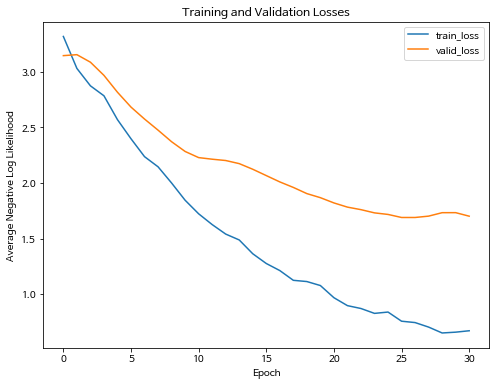

In [36]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

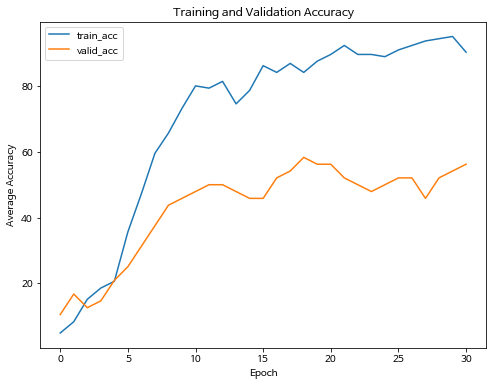

In [37]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

### 모델 저장하기

In [42]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'mobilenet_v2'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()
        
    elif model == 'mobileNet_v2' or 'mobileNet':
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()
          

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [43]:
save_checkpoint(model, path=checkpoint_path)

/home/nlplab/anaconda3/envs/WSD/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/nlplab/anaconda3/envs/WSD/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/nlplab/anaconda3/envs/WSD/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/nlplab/anaconda3/envs/WSD/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LogSoftmax. It won't be checked for correctness upon 

### 모델 불러오기

In [45]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'mobilenet_v2'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'mobilenet_v2' or 'mobileNet':
        model = models.mobilenet_v2(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']
    
    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [46]:
model, optimizer = load_checkpoint(path=checkpoint_path)

2,255,897 total parameters.
32,025 total gradient parameters.


In [47]:
if multi_gpu:
    summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)
else:
    summary(model, input_size=(3, 224, 224), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 32, 112, 112]             864
       BatchNorm2d-2        [128, 32, 112, 112]              64
             ReLU6-3        [128, 32, 112, 112]               0
            Conv2d-4        [128, 32, 112, 112]             288
       BatchNorm2d-5        [128, 32, 112, 112]              64
             ReLU6-6        [128, 32, 112, 112]               0
            Conv2d-7        [128, 16, 112, 112]             512
       BatchNorm2d-8        [128, 16, 112, 112]              32
  InvertedResidual-9        [128, 16, 112, 112]               0
           Conv2d-10        [128, 96, 112, 112]           1,536
      BatchNorm2d-11        [128, 96, 112, 112]             192
            ReLU6-12        [128, 96, 112, 112]               0
           Conv2d-13          [128, 96, 56, 56]             864
      BatchNorm2d-14          [128, 96,

In [48]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=40,
    print_every=1)

Model has been trained for: 68 epochs.

Epoch: 0	100.00% complete. 0.64 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.2650 	Validation Loss: 1.3263
		Training Accuracy: 98.63%	 Validation Accuracy: 66.67%
Epoch: 1	100.00% complete. 0.62 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.2289 	Validation Loss: 1.3088
		Training Accuracy: 99.32%	 Validation Accuracy: 66.67%
Epoch: 2	100.00% complete. 0.62 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.2630 	Validation Loss: 1.2980
		Training Accuracy: 97.95%	 Validation Accuracy: 68.75%
Epoch: 3	100.00% complete. 0.62 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.2361 	Validation Loss: 1.2842
		Training Accuracy: 99.32%	 Validation Accuracy: 72.92%
Epoch: 4	100.00% complete. 0.62 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.2351 	Validation Loss: 1.2781
		Training Accuracy: 99.32%	 Validation Accuracy: 70.83%
Epoch: 5	100.00% complete. 0.62 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.2505 	Validatio

### Inference 

학습한 모델을 이용하여 test data에 대한 성능 평가 및 데모 구현

In [49]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path).convert('RGB')
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

#### prediction

In [50]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]
    
    print ("  >> ", real_class)
    
    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

### Evaluation: Accuracy

In [51]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

### Evaluation Result

#### Test data 전체에 대한 성능 평가
Top-1 Accurcy / Top-5 Accuracy

In [52]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    acc_list = accuracy(model(features.to('cuda')), targets, topk=(1, 5))
else:
    acc_list = accuracy(model(features), targets, topk=(1, 5))
    
print ("  >> Top1 Accuracy: ", acc_list[0])
print ("  >> Top5 Accuracy: ", acc_list[1])
print("")

  >> Top1 Accuracy:  67.34693908691406
  >> Top5 Accuracy:  94.89795684814453



#### 이미지 카테고리별 성능 평가

In [53]:
def evaluate(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [54]:
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results = evaluate(model, dataloaders['test'], criterion)
results.head()

,class,top1,top5,loss
0,가다랑어간장절임,100.000000,100.0,0.632888
1,고등어봉초밥,75.000000,100.0,0.951662
2,고등어초절임,100.000000,100.0,1.081784
3,금태구이,66.666667,100.0,0.820794
4,달걀구이,100.000000,100.0,0.615460


### Demo

In [64]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

In [57]:
test_image_path1 = testdir + '/' + '전갱이/3.PNG'
x = process_image(test_image_path1)
x.shape

torch.Size([3, 224, 224])

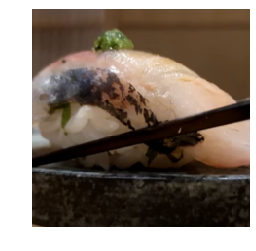

In [58]:
ax, image = imshow_tensor(x)

In [63]:
img, top_p, top_classes, real_class = predict(test_image_path1, model)
#img, top_p, top_classes, real_class = predict(tmp, model)

print("  >> Predicted Result: ", top_classes[0])
print("  >> answer: ", real_class)

  >>  전갱이
  >> Predicted Result:  전갱이
  >> answer:  전갱이


  >>  전갱이


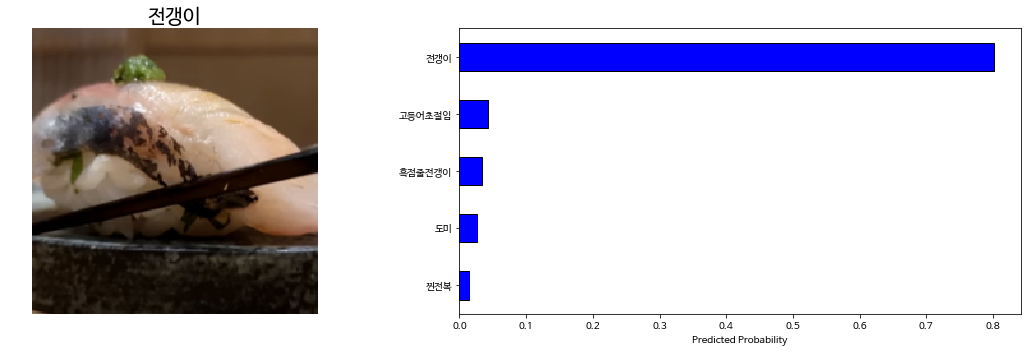

In [65]:
display_prediction(test_image_path1, model, topk=5)

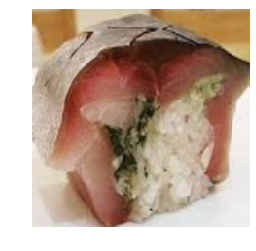

In [67]:
test_image_path2 = testdir + '/' + '고등어봉초밥/9.PNG'
x = process_image(test_image_path2)

ax, image = imshow_tensor(x)

In [69]:
img, top_p, top_classes, real_class = predict(test_image_path2, model)
#img, top_p, top_classes, real_class = predict(tmp, model)

print("  >> Predicted Result: ", top_classes[0])
print("  >> answer: ", real_class)

  >>  고등어봉초밥
  >> Predicted Result:  고등어봉초밥
  >> answer:  고등어봉초밥


  >>  고등어봉초밥


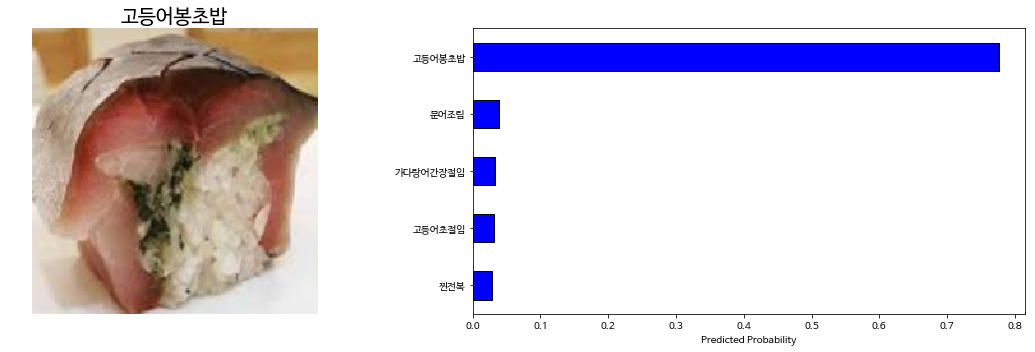

In [71]:
display_prediction(test_image_path2, model, topk=5)